---

## <center><font color=coal><u><big> TP 2 : Apprentissage Statistique Automatique II </big></u></font></center>


In [1]:
# delete warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from transformers import AutoProcessor, AutoModel

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from functools import partial
from pathlib import Path

import torch
import os
import random

from PIL import Image

from tqdm import tqdm           # progress bar

In [3]:
# if yoy need huggingface
# pip install huggingface_hub[hf_xet]

In [4]:
# define paths
path = Path('data/fruits-360_original-size')

# define train path
train = path / 'Training'
print(f"Training Path : {train}")

# define test path
test = path / 'Test'
print(f"Test Path : {test}")

Training Path : data\fruits-360_original-size\Training
Test Path : data\fruits-360_original-size\Test


---

### <center><font color=skyblue><big> Dataset Overview </big></font></center>

Link : "https://www.kaggle.com/datasets/moltean/fruits"

The following fruits, vegetables and nuts are included :

| 1 - (A-C) | 2 - (C-L) | 3 - (L-P) | 4 - (P-Z) |
| :--- | :--- | :--- | :--- |
| 🍎 **Apples** *(Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious)* | 🍊 **Clementine** | 🟢 **Lime** | 🍍 **Pineapple** *(normal, Mini)* |
| 🍑 **Apricot** | 🥥 **Cocos** | 🔴 **Lychee** | 🥜 **Pistachio** |
| 🥑 **Avocado** | 🌽 **Corn** *(with husk)* | 🍊 **Mandarine** | 🐉 **Pitahaya Red** |
| 🥑 **Avocado ripe** | 🥒 **Cucumber** *(ripened, regular)* | 🥭 **Mango** *(Green, Red)* | 🟣 **Plum** *(different varieties)* |
| 🍌 **Banana** *(Yellow, Red, Lady Finger)* | 🟤 **Dates** | 🟣 **Mangostan** | 🔴 **Pomegranate** |
| 🫘 **Beans** | 🍆 **Eggplant** | 🟡 **Maracuja** | 🍊 **Pomelo Sweetie** |
| 🟣 **Beetroot Red** | 🟣 **Fig** | 🍈 **Melon Piel de Sapo** | 🥔 **Potato** *(Red, Sweet, White)* |
| 🫐 **Blackberry** | 🫚 **Ginger Root** | 🍇 **Mulberry** | 🟡 **Quince** |
| 🫐 **Blueberry** | 🟢 **Goosberry** | 🍑 **Nectarine** *(Regular, Flat)* | 🔴 **Rambutan** |
| 🥬 **Cabbage** | 🟠 **Granadilla** | 🥜 **Nut** *(Forest, Pecan)* | 🍇 **Raspberry** |
| 🌵 **Cactus fruit** | 🍇 **Grape** *(Blue, Pink, White)* | 🧅 **Onion** *(Red, White)* | 🔴 **Redcurrant** |
| 🌰 **Caju seed** | 🍊 **Grapefruit** *(Pink, White)* | 🍊 **Orange** | 🟤 **Salak** |
| 🍈 **Cantaloupe** *(2 varieties)* | 🍐 **Guava** | 🥭 **Papaya** | 🍓 **Strawberry** *(normal, Wedge)* |
| ⭐ **Carambula** | 🌰 **Hazelnut** | 🟣 **Passion fruit** | 🔴 **Tamarillo** |
| 🥕 **Carrot** | 🫐 **Huckleberry** | 🍑 **Peach** *(different varieties)* | 🍊 **Tangelo** |
| 🥦 **Cauliflower** | 🟧 **Kaki** | 🍐 **Pear** *(Abate, Forelle, Kaiser, Monster, Red, Stone, Williams)* | 🍅 **Tomato** *(Maroon, Cherry Red, Yellow, not ripened, Heart)* |
| 🍏 **Cherimoya** | 🥝 **Kiwi** | 🟡 **Pepino** | 🌰 **Walnut** |
| 🍒 **Cherry** *(different varieties, Rainier)* | 🥬 **Kohlrabi** | 🫑 **Pepper** *(Red, Green, Orange, Yellow)* | 🍉 **Watermelon** |
| 🍒 **Cherry Wax** *(Yellow, Red, Black)* | 🍊 **Kumsquats** | 🟠 **Physalis** *(normal, with Husk)* | 🥒 **Zucchini** *(green and dark)* |
| 🌰 **Chestnut** | 🍋 **Lemon** *(normal, Meyer)* | | |

---

In [5]:
# --- Parameters ---
EPOCHS = 10
LR = 0.001
BATCH_SIZE = 32
IMG_SIZE = (100, 100)
MODEL_NAME = "google/siglip-so400m-patch14-384"
DEVICE = "cuda"
N_IMAGES = 5000         # number of images to test on

In [6]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### <font color=skyblue><u><big>  1 & 2 : </big></u></font>

In [7]:
# define data augmentation (flip & rotation & zoom)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
])

In [8]:
print(" Starting dataset creation... \n")

# Training Dataset
print("--- Training Dataset ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
print("\n")


# Validation Dataset
print("--- Validation Dataset ---")
val_ds = tf.keras.utils.image_dataset_from_directory(
    train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
print("\n")


# Test Dataset
print("--- Test Dataset ---")
test_ds = tf.keras.utils.image_dataset_from_directory(
    test,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


 Starting dataset creation... 

--- Training Dataset ---
Found 39056 files belonging to 110 classes.
Using 31245 files for training.


--- Validation Dataset ---
Found 39056 files belonging to 110 classes.
Using 7811 files for validation.


--- Test Dataset ---
Found 19415 files belonging to 110 classes.


In [9]:
# Class names and Number of classes
class_names = train_ds.class_names
print(f"Class names: {class_names}")

print("\n")

num_classes = len(class_names)
print(f"Nombre de classes : {num_classes}")

Class names: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Core 1', 'Apple Red Yellow 2', 'Apple worm 1', 'Avocado Black 1', 'Avocado Black 2', 'Avocado Green 1', 'Banana 3', 'Banana 4', 'Beans 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Cabbage red 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cherimoya 1', 'Cherry 3', 'Cherry 4', 'Cherry 5', 'Cherry Rainier 2', 'Cherry Rainier 3', 'Cherry Sour 1', 'Cherry Wax Red 2', 'Cherry Wax Red 3', 'Cherry Wax not ripen 1', 'Cherry Wax not ripen 2', 'Cucumber 1', 'Cucumber 10', 'Cucumber 11', 'Cucumber 3', 'Cucumber 4', 'Cucumber 5', 'Cucumber 6', 'Cucumber 7', 'Cucumber 8', 'Cucumber 9', 'Gooseberry 1', 'Nectarine Flat 2', 'Nut 1', 'Nut 2', 'Nut 3', 'Nut 4', 'Nut 5', 'Onion 2', 'Onion Red 2', 'Onion White Peeled 1', 'Peach 3', 'Peach 4', 'Peach 5', 'Peach 6', 'Pear 1', 'Pea

In [10]:
# ------------------------------------------------------------------------------
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# ------------------------------------------------------------------------------

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Rescaling(1./127.5, offset=-1),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 110)            │       140,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,398,894 (9.15 MB)

 Trainable params: 140,910 (550.43 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Save the best model
checkpoint = ModelCheckpoint(
    "best_fruit_model.keras", 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# stop training if validation stagnates
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

In [14]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
976/977 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4728 - loss: 2.2619
Epoch 1: val_accuracy improved from None to 0.80527, saving model to best_fruit_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 122s 106ms/step - accuracy: 0.6332 - loss: 1.3369 - val_accuracy: 0.8053 - val_loss: 0.5979
Epoch 2/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7983 - loss: 0.6474
Epoch 2: val_accuracy improved from 0.80527 to 0.84996, saving model to best_fruit_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.8079 - loss: 0.6098 - val_accuracy: 0.8500 - val_loss: 0.4696
Epoch 3/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8402 - loss: 0.4963
Epoch 3: val_accuracy improved from 0.84996 to 0.86301, saving model to best_fruit_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.8427 - loss: 0.4919 - val_accuracy: 0.8630 - val_loss: 0.4150
Epoch 4/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8537 - loss: 0.4475
Epoch 4: va

In [15]:
# fine tuning
base_model.trainable = True

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    metrics=['accuracy']
)

more = 5
EPOCHS2 = EPOCHS + more

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history1.epoch[-1],
    epochs=EPOCHS2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 7/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4607 - loss: 2.3393
Epoch 7: val_accuracy improved from 0.87326 to 0.88235, saving model to best_fruit_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - accuracy: 0.5849 - loss: 1.5979 - val_accuracy: 0.8823 - val_loss: 0.3412
Epoch 8/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7725 - loss: 0.7489
Epoch 8: val_accuracy improved from 0.88235 to 0.88631, saving model to best_fruit_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 155s 159ms/step - accuracy: 0.7977 - loss: 0.6562 - val_accuracy: 0.8863 - val_loss: 0.3364
Epoch 9/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8533 - loss: 0.4513
Epoch 9: val_accuracy improved from 0.88631 to 0.89976, saving model to best_fruit_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 147s 151ms/step - accuracy: 0.8642 - loss: 0.4195 - val_accuracy: 0.8998 - val_loss: 0.3022
Epoch 10/15
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8941 - loss: 0.3254

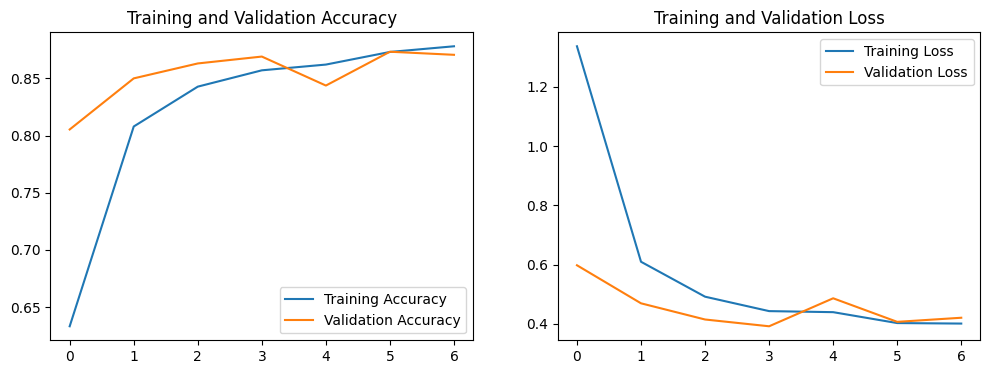

In [16]:
plot_history(history1)

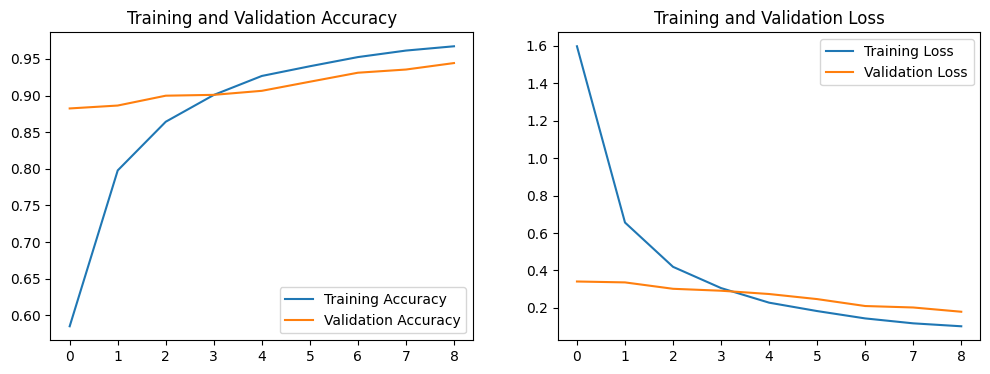

In [17]:
plot_history(history2)

---

#### <font color=skyblue><u><big> 3 : </big></u></font>

Nous avons comparé le modèle (**MobileNetV2 Fine-Tuned + Data Augmentation**) avec le modèle "Baseline" (CNN simple entraîné from scratch) réalisé lors de la Session 1.

| Modèle | Architecture | Data Augmentation | Observations |
| :--- | :--- | :--- | :--- |
| **TP1** | CNN Simple (Conv2D) | Non | Tendance d'Overfitting |
| **TP2** | MobileNetV2 (Transfer) | Oui (Flip, Rotation, Zoom) | Convergence plus rapide et bien meilleure généralisation |


---

#### <font color=skyblue><u><big> 4 : </big></u></font>

implementing VLM Siglip :
<br>
'https://huggingface.co/google/siglip-so400m-patch14-384'

In [18]:
# testing on a reduced number of classes
FRUITS1 = ["Apple", "Banana", "Pear", "Grape", "Strawberry", "Watermelon", "Lemon","Cherry"]
print(f"Testing on {len(FRUITS1)} global classes : {FRUITS1}")

# testing on all classes
unique_classes = set()

for item in test.iterdir():
    if item.is_dir():
        clean_name = item.name.replace('_', ' ')
        base_name = clean_name.split(' ')[0]
        final_name = base_name.title()
        unique_classes.add(final_name)

FRUITS2 = sorted(list(unique_classes))
print(f"Testing on {len(FRUITS2)} global classes : {FRUITS2}")

Testing on 8 global classes : ['Apple', 'Banana', 'Pear', 'Grape', 'Strawberry', 'Watermelon', 'Lemon', 'Cherry']
Testing on 23 global classes : ['Apple', 'Avocado', 'Banana', 'Beans', 'Blackberrie', 'Cabbage', 'Cactus', 'Caju', 'Carrot', 'Cherimoya', 'Cherry', 'Cucumber', 'Eggplant', 'Gooseberry', 'Nectarine', 'Nut', 'Onion', 'Peach', 'Pear', 'Pistachio', 'Quince', 'Tomato', 'Zucchini']


In [19]:
# sort class names 
class_names = sorted([item.name for item in test.iterdir() if item.is_dir()])
print(f"Number of classes (total) : {len(class_names)}")

filtered1 = []
filtered2 = []

# fill filtered lists
for folder in test.iterdir():
    if not folder.is_dir(): 
        continue

    # filter 1
    for target in FRUITS1:
        if target in folder.name: 
            label1 = target
            for img_file in folder.glob("*.jpg"):
                filtered1.append((img_file, label1))
            break
    
    # filter 2
    clean_name = folder.name.replace('_', ' ')
    label2 = clean_name.split(' ')[0].title()
    if label2 == "Blackberrie": 
        label2 = "Blackberry"
    if label2 in FRUITS2:
        for img_file in folder.glob("*.jpg"):
            filtered2.append((img_file, label2))

print(f"Images dans filtered1 : {len(filtered1)}")
print(f"Images dans filtered2 : {len(filtered2)}")

Number of classes (total) : 110
Images dans filtered1 : 7797
Images dans filtered2 : 18809


In [20]:
# -- Siglip model --
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [21]:
def prediction(image_path, classes, model, processor, device) :
    """
    Effectue une classification Zero-Shot sur une image donnée.
    """

    image = Image.open(image_path).convert('RGB')
    texts = [f"a photo of a {c}" for c in classes]
    inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    logits_per_image = outputs.logits_per_image
    probs = torch.sigmoid(logits_per_image) 
    idx = probs.argmax(dim=1).item()
    confidence = probs[0][idx].item()
    
    return classes[idx], confidence

In [22]:
# test on the first filter
random.shuffle(filtered1)
images1 = filtered1[:N_IMAGES]  # test on N_IMAGES

print(f"Number of images found : {len(filtered1)}")
print(f"Starting test on {len(images1)} images :")

y_true1 = []
y_pred1 = []

for img_path1, true_label1 in tqdm(images1):
    pred_label1, conf1 = prediction(img_path1, FRUITS1, model, processor, DEVICE)
    y_true1.append(true_label1)
    y_pred1.append(pred_label1)

Number of images found : 7797
Starting test on 5000 images :


100%|██████████| 5000/5000 [09:20<00:00,  8.92it/s]


In [23]:
# results for the first filter 
print("\n--- Résultats sur les Fruits de FRUITS1 ---")
acc = np.mean(np.array(y_true1) == np.array(y_pred1))
print(f"Accuracy : {acc:.2%}" + "\n")
print(classification_report(y_true1, y_pred1, labels=FRUITS1))


--- Résultats sur les Fruits de FRUITS1 ---
Accuracy : 83.98%

              precision    recall  f1-score   support

       Apple       0.93      0.91      0.92      1907
      Banana       1.00      1.00      1.00       105
        Pear       0.95      0.95      0.95      1488
       Grape       0.00      0.00      0.00         0
  Strawberry       0.00      0.00      0.00         0
  Watermelon       0.00      0.00      0.00         0
       Lemon       0.00      0.00      0.00         0
      Cherry       0.94      0.63      0.75      1500

    accuracy                           0.84      5000
   macro avg       0.48      0.44      0.45      5000
weighted avg       0.94      0.84      0.88      5000



In [24]:
# test on the second filter
random.shuffle(filtered2)
images2 = filtered2[:N_IMAGES]  # test on N_IMAGES

print(f"Number of images found : {len(filtered2)}")
print(f"Starting test on {len(images2)} images :")

y_true2 = []
y_pred2 = []

for img_path2, true_label2 in tqdm(images2):
    pred_label2, conf2 = prediction(img_path2, FRUITS2, model, processor, DEVICE)
    y_true2.append(true_label2)
    y_pred2.append(pred_label2)

Number of images found : 18809
Starting test on 5000 images :


100%|██████████| 5000/5000 [14:12<00:00,  5.86it/s]


In [25]:
# results for the second filter 
print("\n--- Résultats sur les Fruits de FRUITS2 ---")
acc = np.mean(np.array(y_true2) == np.array(y_pred2))
print(f"Accuracy : {acc:.2%}" + "\n")
print(classification_report(y_true2, y_pred2, labels=FRUITS2))


--- Résultats sur les Fruits de FRUITS2 ---
Accuracy : 77.56%

              precision    recall  f1-score   support

       Apple       0.97      0.80      0.88      1394
     Avocado       0.67      0.89      0.76       197
      Banana       0.76      1.00      0.86        44
       Beans       0.50      0.05      0.09        21
 Blackberrie       0.00      0.00      0.00         0
     Cabbage       0.93      1.00      0.96        27
      Cactus       1.00      0.79      0.88       137
        Caju       1.00      0.28      0.43        18
      Carrot       0.73      1.00      0.84        16
   Cherimoya       0.75      0.85      0.80        85
      Cherry       0.87      0.61      0.71       500
    Cucumber       1.00      0.71      0.83       478
    Eggplant       0.44      1.00      0.62        24
  Gooseberry       0.53      0.38      0.44        42
   Nectarine       0.17      0.57      0.27        46
         Nut       0.30      0.98      0.46        94
       Onion     

---

#### <font color=skyblue><u><big> 5 : </big></u></font>

In [26]:
# define confusion matrix 
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Classe')
    plt.title('Matrice de Confusion (VLM Zero-Shot)')
    plt.show()

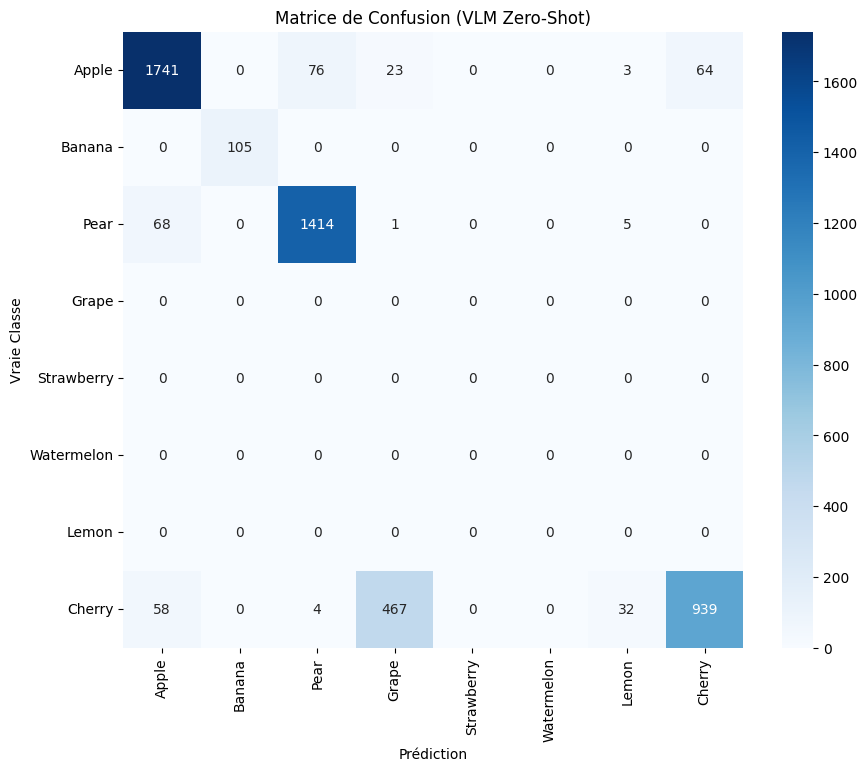

In [27]:
# for the first filter
plot_confusion_matrix(y_true1, y_pred1, FRUITS1)

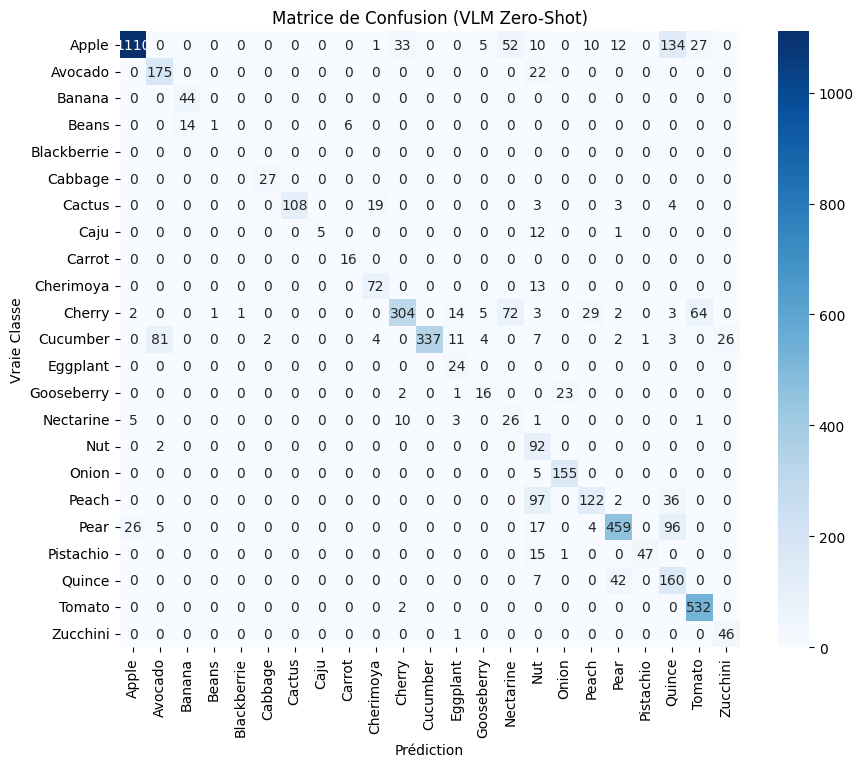

In [28]:
# for the second filter
plot_confusion_matrix(y_true2, y_pred2, FRUITS2)

#### **Analyse Technique des Résultats :**
* **FRUITS1 :** Accuracy de **84%**.
    * Le modèle est excellent sur les concepts visuels forts (Banane : 100%, Poire : 95%).
    * Cependant, il montre déjà des faiblesses sur des fruits plus petits ou ambigus (Cerise).

* **FRUITS2 :** Accuracy de **78%**.
    * La performance chute dès qu'on introduit des fruits visuellement proches.
    * Cas de la Nectarine : seulement **17%**, le modèle échoue pour ce fruit.
    * Fruits Rares : Les classes moins courantes (**Caju, Beans**) ont des scores F1 très bas.

<br>

#### **Impact :**
Si ce modèle VLM était déployé, les conséquences seraient :

1.  **Pertes Financières :**
    * Confondre des nectarines par exemple avec d'autres fruits entraînerait des erreurs de stock massives et des pertes de marge (prix au kilo différent).

2.  **Coûts de Main-d'œuvre :**
    * Les erreurs de prédiction nécessiterait de la main d'œuvre pour corriger le tout.

3.  **Vitesse du modèle :**
    * Le modèle VLM (SigLIP) est beaucoup plus lent à que le MobileNetV2 ce qui entraînerait un retard.

**Conclusion :** Le VLM ne doit pas être utilisé pour le tri principal car trop imprécis et lent. Il doit être réservé à la gestion des exceptions.